In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import mibian
import numpy as np
import scipy as sp
import sys

/Users/jteruya/.pyenv/versions/3.8.0/lib/python3.8/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


## Matlabplot Display Parameters

In [2]:
# Display Plot within Jupyter Notebook
%matplotlib inline
# Default Plot Size
plt.rcParams['figure.figsize'] = [10, 10]

## Import Common Classes

In [3]:
%run common/Equity.ipynb

## Platform Dependent Environment Variables
Ensuring the home directory is used regardless of OS type:
- Windows OS : `HOMEDRIVE`
- Mac/Linux/Unix OS : `HOME`

In [4]:
env_home = os.getenv('HOMEDRIVE') if sys.platform.startswith('win') else os.getenv('HOME')

## Load Vix Historical File
This file was loaded from [here](https://finance.yahoo.com/quote/%5EVIX/history/)

In [5]:
# Data File Location
vix_data = env_home + '/Documents/platypus/vix/vix_20200509.csv'
# Instantiate Vix Object
vix = equity('vix', vix_data)
# Min Max Scale Field "Adj Close"
vix.min_max_scale('Adj Close')

## Load Citi Historical File
This file was loaded from [here](https://finance.yahoo.com/quote/C/history?period1=1575849600&period2=1588982400&interval=1d&filter=history&frequency=1d)

In [6]:
# Data File Location
citi_data = env_home + '/Documents/platypus/citi/citi_20200509.csv'
# Instantiate Vix Object
citi = equity('citi', citi_data)
# Calculate Historical Volatility
citi.historical_volatility(30)
# Min Max Scale Field "Adj Close"
citi.min_max_scale('Adj Close')
# Min Max Scale Field "Rolling Volatility"
citi.min_max_scale('Rolling Volatility')

## Visualization of VIX and Citi

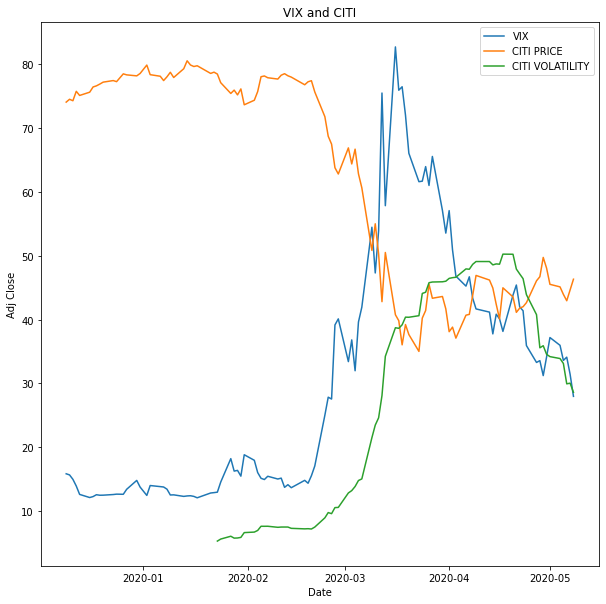

In [7]:
plt.plot(vix.df['Adj Close'], label="VIX")
plt.plot(citi.df['Adj Close'], label="CITI PRICE")
plt.plot(citi.df['Rolling Volatility'], label="CITI VOLATILITY")
plt.xlabel('Date')
plt.ylabel('Adj Close')
plt.title('VIX and CITI')
plt.legend()
plt.show()

## Visualization of VIX and Citi (Min-Max Normalized)

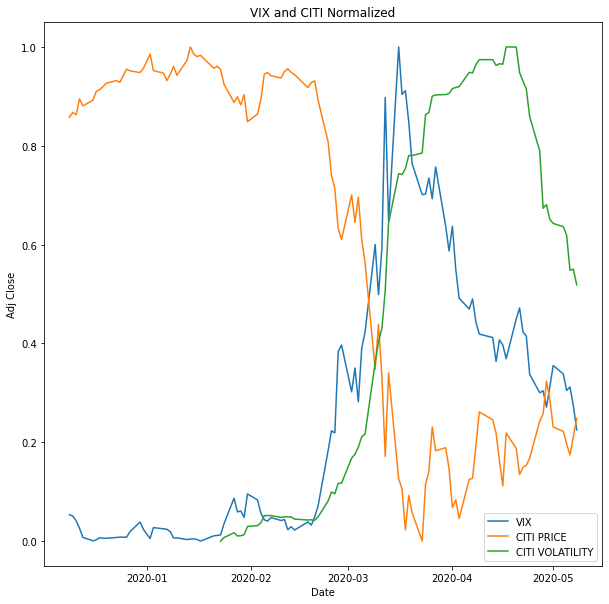

In [8]:
plt.plot(vix.df['Adj Close Scaled'], label="VIX")
plt.plot(citi.df['Adj Close Scaled'], label="CITI PRICE")
plt.plot(citi.df['Rolling Volatility Scaled'], label="CITI VOLATILITY")
plt.xlabel('Date')
plt.ylabel('Adj Close')
plt.title('VIX and CITI Normalized')
plt.legend()
plt.show()

## Investigating Correlation

In [9]:
scaled_data = [pd.DataFrame(citi.df['Adj Close Scaled']), pd.DataFrame(citi.df['Rolling Volatility Scaled']), pd.DataFrame(vix.df['Adj Close Scaled'])]

In [10]:
df_scaled = pd.concat(scaled_data, axis =1, join='outer', ignore_index=False, keys=['citiprice_scaled', 'citivol_scaled', 'vix_scaled'],
          levels=None, names=None, verify_integrity=False, copy=True)

In [11]:
df_scaled = df_scaled.dropna(axis='rows')

In [12]:
df_scaled.corr()

,,citiprice_scaled,citivol_scaled,vix_scaled
,,Adj Close Scaled,Rolling Volatility Scaled,Adj Close Scaled
citiprice_scaled,Adj Close Scaled,1.000000,-0.940928,-0.827008
citivol_scaled,Rolling Volatility Scaled,-0.940928,1.000000,0.714761
vix_scaled,Adj Close Scaled,-0.827008,0.714761,1.000000


## Fitting Data Using Linear Regression

In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [14]:
lr = LinearRegression()

### CITI Price vs CITI Volatility

In [15]:
X = df_scaled['citiprice_scaled']
y = df_scaled['citivol_scaled']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [16]:
lr.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [17]:
print('Coefficients: \n', lr.coef_)
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(X_train, y_train))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_train, X_train))

Coefficients: 
 [[-0.99125043]]
Mean squared error: 0.48
Coefficient of determination: -2.66


In [18]:
citivol_y_pred = lr.predict(X_test)

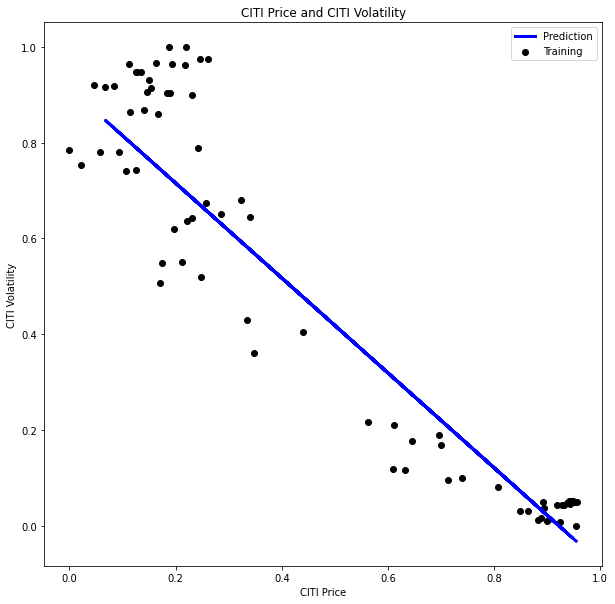

In [19]:
plt.scatter(X,y, color='black', label='Training')
plt.plot(X_test, citivol_y_pred, color='blue', linewidth=3, label='Prediction')
plt.xlabel('CITI Price')
plt.ylabel('CITI Volatility')
plt.title('CITI Price and CITI Volatility')
plt.legend()
plt.show()

### VIX vs CITI Volatility

In [20]:
# vix vs citi vol
X = df_scaled['vix_scaled']
y = df_scaled['citivol_scaled']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [21]:
lr.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [22]:
print('Coefficients: \n', lr.coef_)
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(X_train, y_train))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_train, X_train))

Coefficients: 
 [[1.03303732]]
Mean squared error: 0.08
Coefficient of determination: 0.47


In [23]:
citivol_y_pred = lr.predict(X_test)

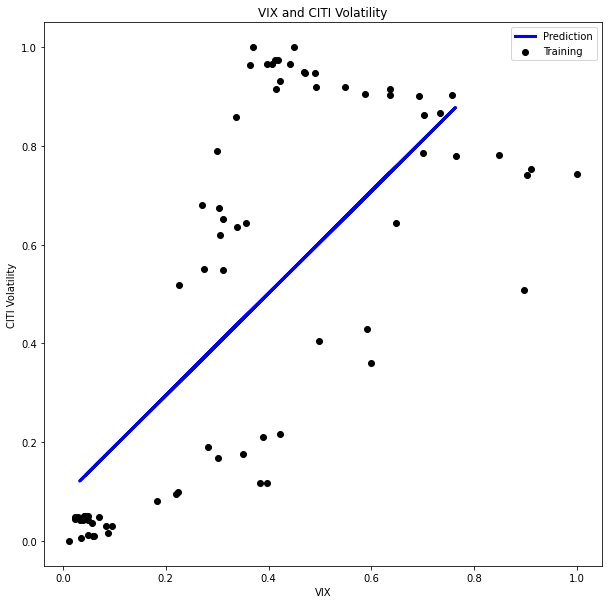

In [24]:
plt.scatter(X,y, color='black', label='Training')
plt.plot(X_test, citivol_y_pred, color='blue', linewidth=3, label='Prediction')
plt.xlabel('VIX')
plt.ylabel('CITI Volatility')
plt.title('VIX and CITI Volatility')
plt.legend()
plt.show()

### VIX vs CITI Price

In [25]:
# vix vs citi price
X = df_scaled['vix_scaled']
y = df_scaled['citiprice_scaled']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [26]:
lr.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [27]:
print('Coefficients: \n', lr.coef_)
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(X_train, y_train))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_train, X_train))

Coefficients: 
 [[-1.04812632]]
Mean squared error: 0.35
Coefficient of determination: -2.04


In [28]:
citiprice_y_pred = lr.predict(X_test)

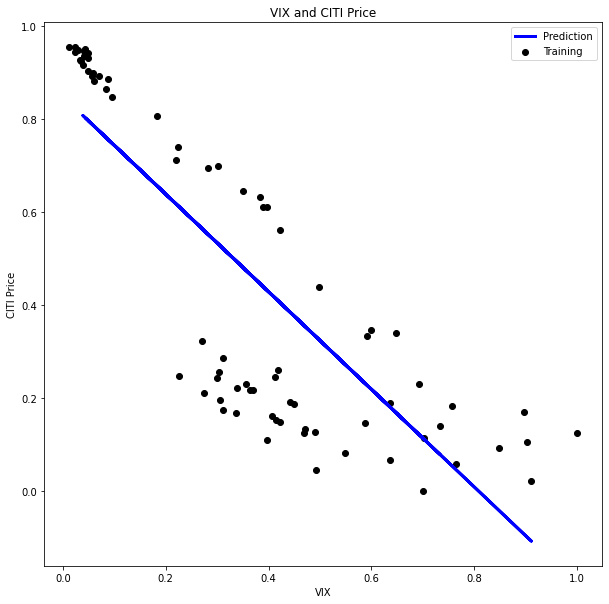

In [29]:
plt.scatter(X,y, color='black', label='Training')
plt.plot(X_test, citiprice_y_pred, color='blue', linewidth=3, label='Prediction')
plt.xlabel('VIX')
plt.ylabel('CITI Price')
plt.title('VIX and CITI Price')
plt.legend()
plt.show()